<a href="https://colab.research.google.com/github/senthilchandrasegaran/designing-intelligence/blob/main/notebooks/paralinguistic-visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Transcripts (organised by speaker) created using the Jefferson Conventions
This is an example of a how the annotations that form part of the Jefferson Transcription Conventions can be used to visually analyse the [paralinguistic](https://en.wikipedia.org/wiki/Paralanguage) components of the transcript. 

This notebook is set up to analyse transcripts with multiple speakers.

## Set up the Notebook
Since you are likely to run the notebook using Colab, you do not have to do change anything in the cell(s) below. However, if you plan to clone this repository and run it locally, please edit the cell below according to the instructions in the comments.

In [1]:
environment = 'local'

# Comment out the lines below until the line marked with '#---'
# !git clone https://github.com/senthilchandrasegaran/designing-intelligence
# %cd /content/designing-intelligence/notebooks/
# !git pull
# environment = 'colab'
#---

if environment == 'colab' :
    path = '/content/designing-intelligence/'
else :
    path = '../'

import re
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import pprint as pp
import seaborn as sns
from IPython.display import Markdown, display



In [2]:
def printmd(string):
    display(Markdown(string))

## Read the Transcript
For now, this notebook is set up to read the transcript as a text file. Please refer to the sample transcript in the 'data' folder to see what it looks like. The cells below read the transcript and print it out for verification.

In [3]:
with open(path + 'data/transcript-dana-annie.txt', 'r') as fo:
    transcript_text = fo.read()

## Visualizing Pauses
### Counting the Pauses
We use [regular expressions in python](https://www.w3schools.com/python/python_regex.asp) to search for specific annotations in the transcript and collect them. In the function below, we look for all occurrences of characters within parentheses and collect the matches as well as the locations in the transcript (obtained by counting the characters including spaces up to the match) where the match is found.

In [15]:
def load_transcript_into_dataframe(transcript):
    transcript_lines = transcript.split('\n')
    processed_list = []
    for line in transcript_lines :
        if len(line.split(':')) > 1 :
            speaker = line.split(':')[0]
            speech = (':').join(line.split(':')[1:])
            line_obj = { 'speaker' : speaker, 'speech_turn' : speech}
            processed_list.append(line_obj)
        else :
            speaker = processed_list[-1]['speaker']
            speech = processed_list[-1]['speech_turn']
            new_speech = speech + ' ' + line
            processed_list[-1]['speech_turn'] = new_speech
    df = pd.DataFrame(processed_list)
    return df

In [16]:
transcript_df = load_transcript_into_dataframe(transcript_text)
transcript_df.sample(3)

,speaker,speech_turn
37,Dana,"Yeah, it doesn’t make sense (4.0) yeah the(.)..."
148,Annie,parrots↑ swinging (2.0) that’s↑ three right↑y...
28,Annie,Ahh


In [17]:
all_speakers = list(set(list(transcript_df['speaker'])))
all_speakers

['Dana', 'Annie/Dana', 'Peter', 'Annie/ Dana', 'Annie', ' Dana']

In [25]:
def get_pauses(df, speaker):
    regex=r"\([0-9\.]+\)"
    match_list = []
    speaker_df = df[df.speaker == speaker]
    transcript_text = (' ').join(list(speaker_df['speech_turn']))
    for match in re.finditer(regex, transcript_text):
        match_list.append({'start' : match.span()[0], 'end' : match.span()[1], 'match' : match.group()})
    df = pd.DataFrame(match_list)
    return df


In [27]:
pauses_df = get_pauses(transcript_df, 'Dana')
pauses_df.sample(3)

,start,end,match
1,332,335,(.)
14,1119,1124,(4.0)
9,892,895,(.)


### Plotting the Pauses
We then plot the pauses along the length of the transcript, with each "kind" of pause on a separate row.

In [32]:
def sortnumber(elem):
    elem_no_pars=elem[1:-1]
    if elem_no_pars == '.' or elem_no_pars == '' :
        elem_num = 0.0
    else :
        elem_num = float(elem_no_pars)
    return elem_num

def pause_timeline(df, speaker):
    pause_types = list(set(list(df['match'])))
    pause_types.sort(key=sortnumber)
    fig = plt.figure(figsize=[10, len(pause_types)/3], dpi=300)
    p = sns.stripplot(data = df, x = 'start', y = 'match', order=pause_types,
                      s=10, marker="$\u007C$", jitter=False)
    plt.title('Pauses for ' + speaker)
    plt.savefig(path + 'plots/pauses-timeline.pdf', bbox_inches='tight')
    p.set_ylim([-1,len(pause_types)])

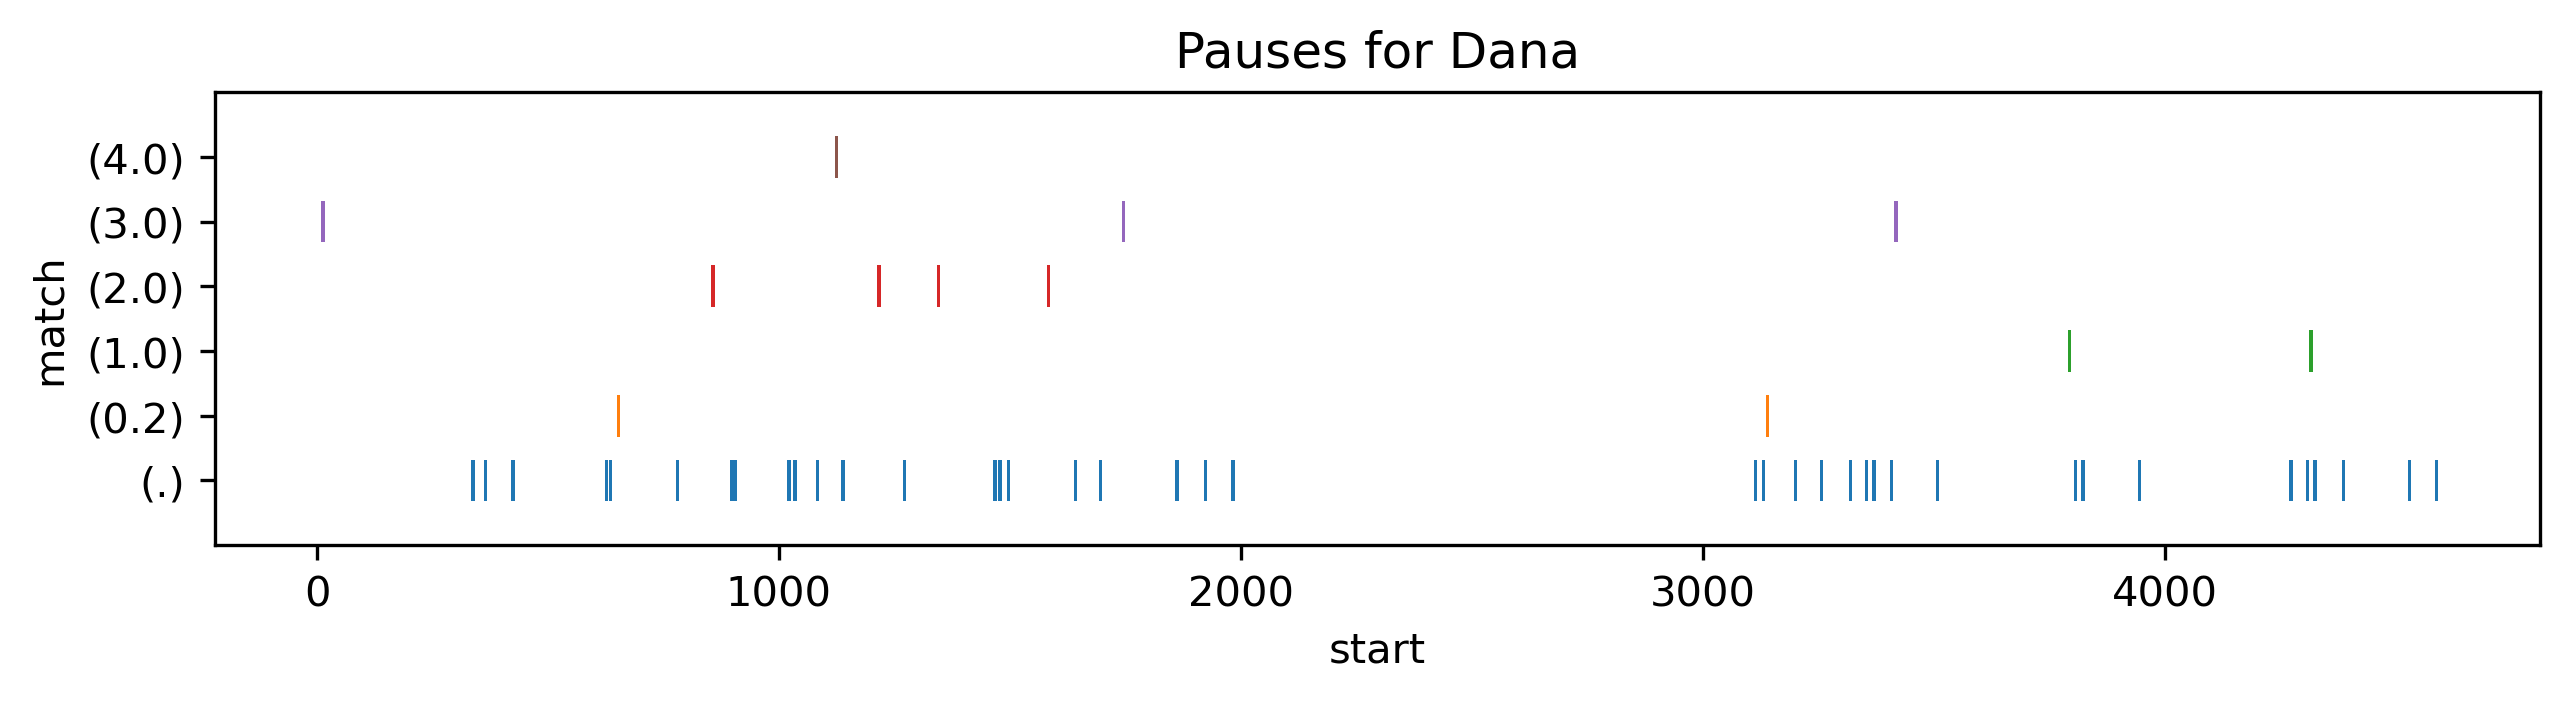

In [33]:
pause_timeline(pauses_df, 'Dana')

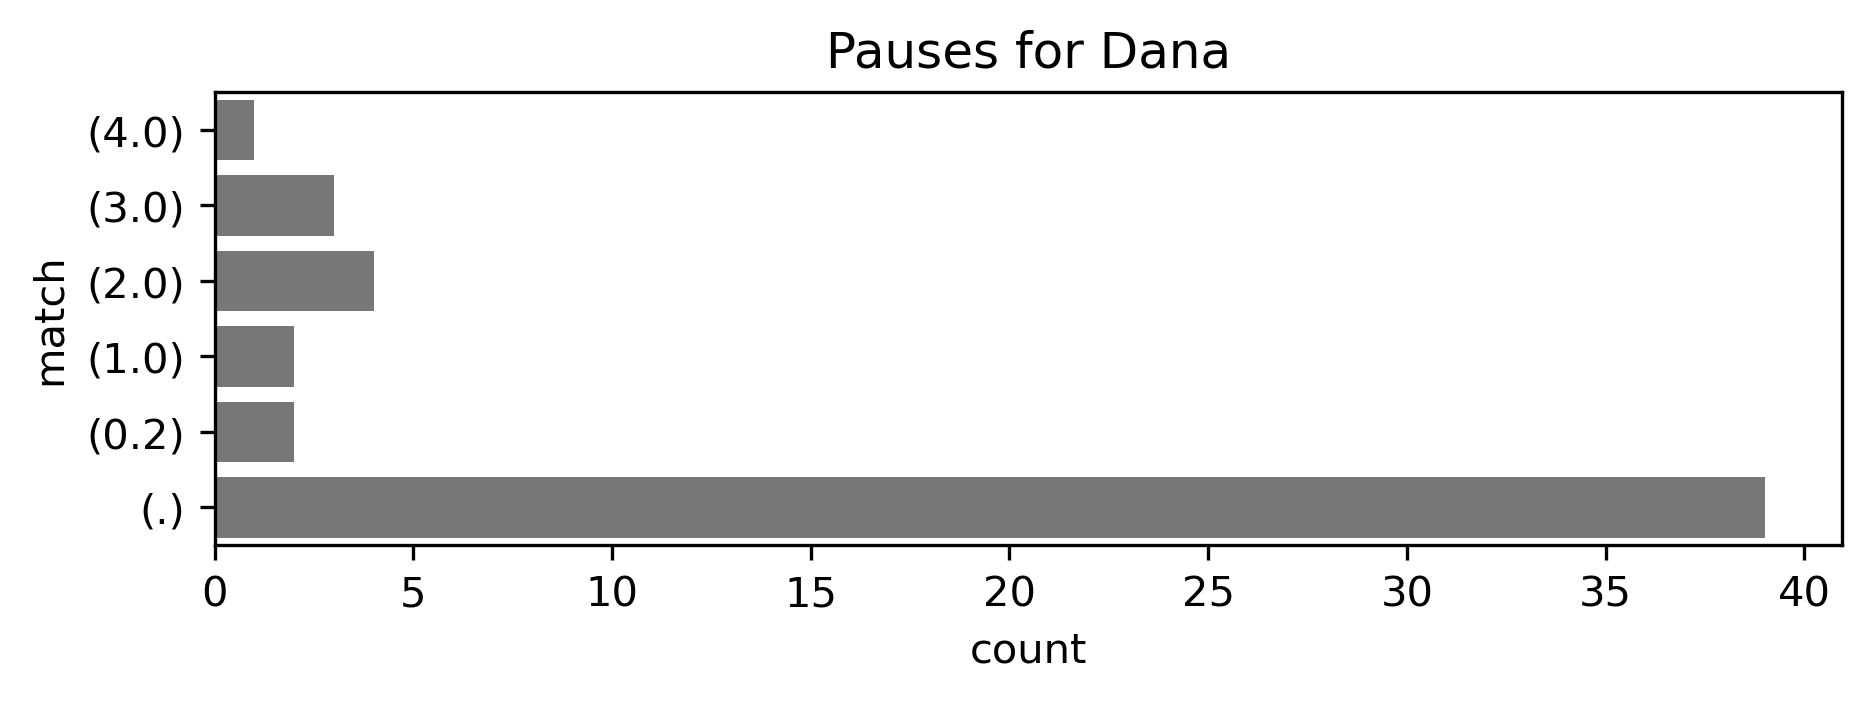

In [60]:
def pause_counts(df, speaker):
    pause_types = list(set(list(df['match'])))
    pause_types.sort(key=sortnumber, reverse=True)
    fig = plt.figure(figsize=[7, len(pause_types)/3], dpi=300)
    p = sns.countplot(data = df, y = 'match', order=pause_types, color='#777')
    plt.title('Pauses for ' + speaker)
    plt.savefig(path + 'plots/pause-counts.pdf', bbox_inches='tight')
#     p.set_ylim([-1,len(pause_types)])

pause_counts(pauses_df, 'Dana')

## Visualizing Intonations
We use an approach similar to visualizing the pauses above to count and visualize upward (↑) and downward (↓) intonations.

In [45]:
def get_intonations(df, speaker):
    regex=r"↑|↓"
    match_list = []
    speaker_df = df[df.speaker == speaker]
    transcript_text = (' ').join(list(speaker_df['speech_turn']))
    for match in re.finditer(regex, transcript_text):
        match_list.append({'start' : match.span()[0], 'end' : match.span()[1], 'match' : match.group()})
    df = pd.DataFrame(match_list)
    return df

In [46]:
intonations_df = get_intonations(transcript_df, 'Dana')
intonations_df.sample(3)

,start,end,match
4,2074,2075,↑
1,519,520,↑
10,3603,3604,↓


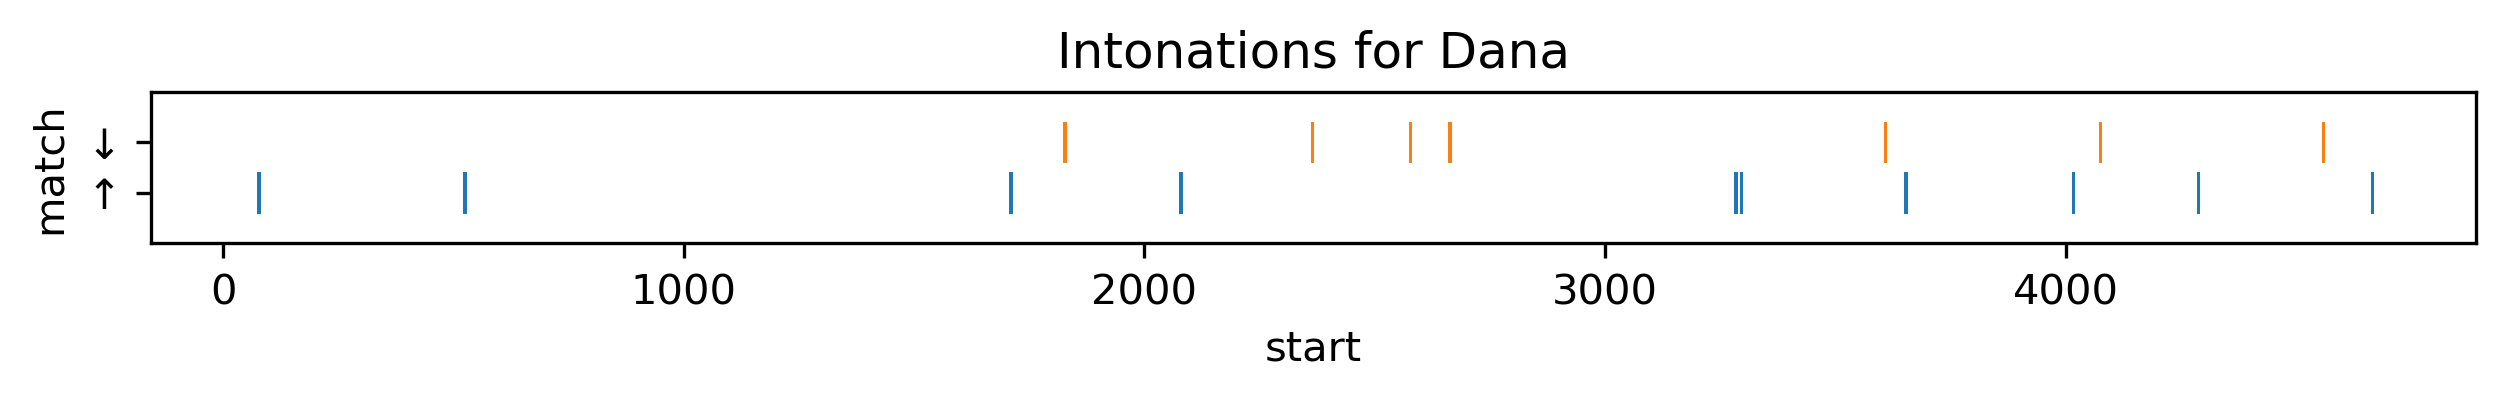

In [49]:
def intonation_timeline(df, speaker):
    intonation_types = list(set(list(df['match'])))
    fig = plt.figure(figsize=[10, len(intonation_types)/3], dpi=300)
    p = sns.stripplot(data = df, x = 'start', y = 'match',
                      s=10, marker="$\u007C$", jitter=False)
    p.set_ylim([-1,len(intonation_types)])
    plt.title('Intonations for ' + speaker)
    plt.savefig(path + 'plots/intonation-timeline.pdf', bbox_inches='tight')

intonation_timeline(intonations_df, 'Dana')


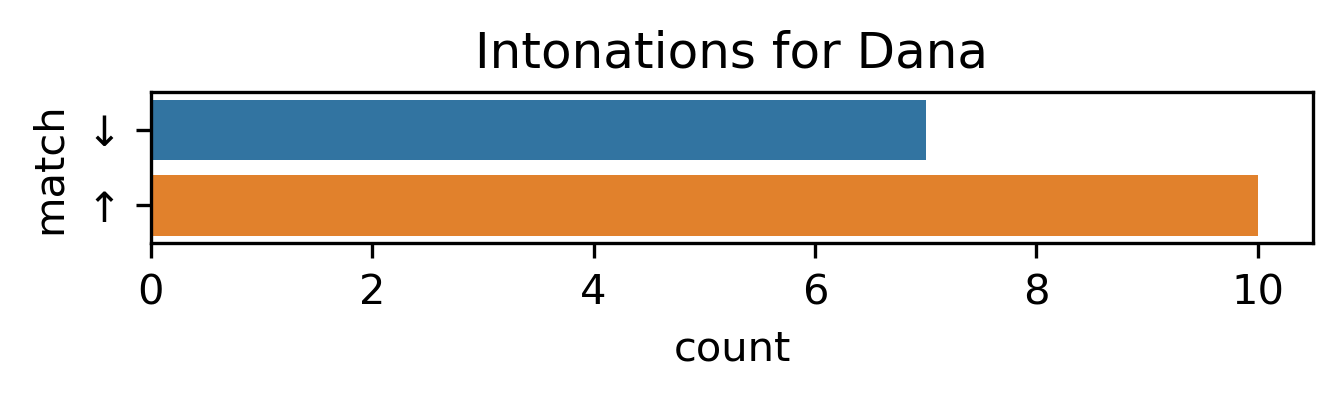

In [52]:
def intonation_counts(df, speaker):
    intonation_types = list(set(list(df['match'])))
    intonation_types.sort(reverse=True)
    fig = plt.figure(figsize=[5, len(intonation_types)/3], dpi=300)
    p = sns.countplot(data = df, y = 'match', order=intonation_types)
    plt.title('Intonations for ' + speaker)
    plt.savefig(path + 'plots/intonation-counts.pdf', bbox_inches='tight')

intonation_counts(intonations_df, 'Dana')
